# --CP1--
# Brain MRI segmentation
brain MRI 이미지를 딥러닝을 이용해 학습하여 종양이 있을경우 해당 부위를 segmentatinon.

In [ ]:
cd OneDrive/바탕 화면/AI_05_정인중

C:\Users\jij16\OneDrive\바탕 화면\AI_05_정인중


In [ ]:
ls

 Volume in drive C has no label.
 Volume Serial Number is F4C8-6917

 Directory of C:\Users\jij16\OneDrive\諛뷀깢 �솕硫�\AI_05_�젙�씤以�

2021-12-20  �삤�썑 08:10    <DIR>          .
2021-12-20  �삤�썑 08:10    <DIR>          ..
2021-12-20  �삤�썑 08:07       372,801,816 1.h5
2021-12-20  �삤�썑 08:10       372,801,816 2.h5
2021-12-13  �삤�썑 10:20    <DIR>          kaggle_3m
2021-12-13  �삤�썑 10:20    <DIR>          lgg-mri-segmentation
2021-12-20  �삤�썑 08:03    <DIR>          logs
               2 File(s)    745,603,632 bytes
               5 Dir(s)  33,270,374,400 bytes free


In [ ]:
%load_ext tensorboard

In [ ]:
from glob import glob
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import cv2
import pandas as pd
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras import backend as K
import random
import numpy as np
import datetime

In [ ]:
# Clear any logs from previous runs
!rm -rf ./logs/

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()  # local GPU를 사용할 준비가 된걸 확인할 수 있습니다.

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 9270834469340590266,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 2196032718
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 15024659740174723322
 physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1060 3GB, pci bus id: 0000:08:00.0, compute capability: 6.1"]

In [ ]:
train_files = []
mask_files = glob('lgg-mri-segmentation/kaggle_3m/*/*_mask*')

for i in mask_files:
    train_files.append(i.replace('_mask',''))

print(train_files[0])
print(mask_files[0])

lgg-mri-segmentation/kaggle_3m\TCGA_CS_4941_19960909\TCGA_CS_4941_19960909_10.tif
lgg-mri-segmentation/kaggle_3m\TCGA_CS_4941_19960909\TCGA_CS_4941_19960909_10_mask.tif


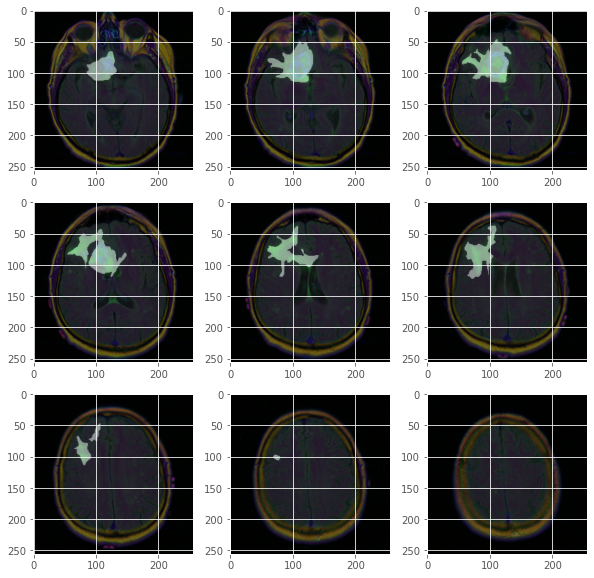

In [ ]:
rows,cols=3,3
fig=plt.figure(figsize=(10,10))
for i in range(1,rows*cols+1):
    fig.add_subplot(rows,cols,i)
    img_path=train_files[i]
    msk_path=mask_files[i]
    img=cv2.imread(img_path)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    msk=cv2.imread(msk_path)
    plt.imshow(img)
    plt.imshow(msk,alpha=0.4)
plt.show()

In [ ]:
df = pd.DataFrame({"filename": train_files, 'mask' : mask_files})

In [ ]:
print(df.shape)
df.head()

(3929, 2)


,filename,mask
0,lgg-mri-segmentation/kaggle_3m\TCGA_CS_4941_19...,lgg-mri-segmentation/kaggle_3m\TCGA_CS_4941_19...
1,lgg-mri-segmentation/kaggle_3m\TCGA_CS_4941_19...,lgg-mri-segmentation/kaggle_3m\TCGA_CS_4941_19...
2,lgg-mri-segmentation/kaggle_3m\TCGA_CS_4941_19...,lgg-mri-segmentation/kaggle_3m\TCGA_CS_4941_19...
3,lgg-mri-segmentation/kaggle_3m\TCGA_CS_4941_19...,lgg-mri-segmentation/kaggle_3m\TCGA_CS_4941_19...
4,lgg-mri-segmentation/kaggle_3m\TCGA_CS_4941_19...,lgg-mri-segmentation/kaggle_3m\TCGA_CS_4941_19...


In [ ]:
x = zip(df['filename'][:5], df['mask'][:5])
for a, b in x:
    print(a,b)

lgg-mri-segmentation/kaggle_3m\TCGA_CS_4941_19960909\TCGA_CS_4941_19960909_10.tif lgg-mri-segmentation/kaggle_3m\TCGA_CS_4941_19960909\TCGA_CS_4941_19960909_10_mask.tif
lgg-mri-segmentation/kaggle_3m\TCGA_CS_4941_19960909\TCGA_CS_4941_19960909_11.tif lgg-mri-segmentation/kaggle_3m\TCGA_CS_4941_19960909\TCGA_CS_4941_19960909_11_mask.tif
lgg-mri-segmentation/kaggle_3m\TCGA_CS_4941_19960909\TCGA_CS_4941_19960909_12.tif lgg-mri-segmentation/kaggle_3m\TCGA_CS_4941_19960909\TCGA_CS_4941_19960909_12_mask.tif
lgg-mri-segmentation/kaggle_3m\TCGA_CS_4941_19960909\TCGA_CS_4941_19960909_13.tif lgg-mri-segmentation/kaggle_3m\TCGA_CS_4941_19960909\TCGA_CS_4941_19960909_13_mask.tif
lgg-mri-segmentation/kaggle_3m\TCGA_CS_4941_19960909\TCGA_CS_4941_19960909_14.tif lgg-mri-segmentation/kaggle_3m\TCGA_CS_4941_19960909\TCGA_CS_4941_19960909_14_mask.tif


In [ ]:
df_train, df_test = train_test_split(df,test_size = 0.2)
df_train, df_val = train_test_split(df_train,test_size = 0.2)
print(df_train.shape)
print(df_val.shape)
print(df_test.shape)

(2514, 2)
(629, 2)
(786, 2)


In [ ]:
def unet(input_size=(256,256,3)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(64, (3, 3), padding='same')(inputs)
    bn1 = Activation('relu')(conv1)
    conv1 = Conv2D(64, (3, 3), padding='same')(bn1)
    bn1 = BatchNormalization(axis=3)(conv1)
    bn1 = Activation('relu')(bn1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)

    conv2 = Conv2D(128, (3, 3), padding='same')(pool1)
    bn2 = Activation('relu')(conv2)
    conv2 = Conv2D(128, (3, 3), padding='same')(bn2)
    bn2 = BatchNormalization(axis=3)(conv2)
    bn2 = Activation('relu')(bn2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)

    conv3 = Conv2D(256, (3, 3), padding='same')(pool2)
    bn3 = Activation('relu')(conv3)
    conv3 = Conv2D(256, (3, 3), padding='same')(bn3)
    bn3 = BatchNormalization(axis=3)(conv3)
    bn3 = Activation('relu')(bn3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)

    conv4 = Conv2D(512, (3, 3), padding='same')(pool3)
    bn4 = Activation('relu')(conv4)
    conv4 = Conv2D(512, (3, 3), padding='same')(bn4)
    bn4 = BatchNormalization(axis=3)(conv4)
    bn4 = Activation('relu')(bn4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(bn4)

    conv5 = Conv2D(1024, (3, 3), padding='same')(pool4)
    bn5 = Activation('relu')(conv5)
    conv5 = Conv2D(1024, (3, 3), padding='same')(bn5)
    bn5 = BatchNormalization(axis=3)(conv5)
    bn5 = Activation('relu')(bn5)

    up6 = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bn5), conv4], axis=3)
    conv6 = Conv2D(512, (3, 3), padding='same')(up6)
    bn6 = Activation('relu')(conv6)
    conv6 = Conv2D(512, (3, 3), padding='same')(bn6)
    bn6 = BatchNormalization(axis=3)(conv6)
    bn6 = Activation('relu')(bn6)

    up7 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(bn6), conv3], axis=3)
    conv7 = Conv2D(256, (3, 3), padding='same')(up7)
    bn7 = Activation('relu')(conv7)
    conv7 = Conv2D(256, (3, 3), padding='same')(bn7)
    bn7 = BatchNormalization(axis=3)(conv7)
    bn7 = Activation('relu')(bn7)

    up8 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(bn7), conv2], axis=3)
    conv8 = Conv2D(128, (3, 3), padding='same')(up8)
    bn8 = Activation('relu')(conv8)
    conv8 = Conv2D(128, (3, 3), padding='same')(bn8)
    bn8 = BatchNormalization(axis=3)(conv8)
    bn8 = Activation('relu')(bn8)

    up9 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(bn8), conv1], axis=3)
    conv9 = Conv2D(64, (3, 3), padding='same')(up9)
    bn9 = Activation('relu')(conv9)
    conv9 = Conv2D(64, (3, 3), padding='same')(bn9)
    bn9 = BatchNormalization(axis=3)(conv9)
    bn9 = Activation('relu')(bn9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(bn9)

    return Model(inputs=[inputs], outputs=[conv10])

In [ ]:
model = unet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 64) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       activation[0][0]                 
______________________________________________________________________________________________

In [ ]:
EPOCHS = 100
BATCH_SIZE = 4

In [ ]:
width = 256
height = 256

In [ ]:
def train_generator(data_frame, gen, batch_size,
        image_color_mode="rgb",
        mask_color_mode="grayscale",
        target_size=(256,256),
        seed=1):

    
    image_generator = gen.flow_from_dataframe(
        data_frame,
        x_col = "filename",
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        seed = seed)

    mask_generator = gen.flow_from_dataframe(
        data_frame,
        x_col = "mask",
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        seed = seed)

    train_gen = zip(image_generator, mask_generator)
    
    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img,mask)

def adjust_data(img,mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    
    return (img, mask)

In [ ]:
# Train ImageDataGenerator
train_gen = ImageDataGenerator(horizontal_flip=True)
# val ImageDataGenerator                
val_gen = ImageDataGenerator()
# Test ImageDataGenerator
test_gen = ImageDataGenerator()


train_flow_gen = train_generator(df_train, train_gen, BATCH_SIZE)
val_flow_gen = train_generator(df_val, val_gen, BATCH_SIZE)
test_flow_gen = train_generator(df_test, test_gen, BATCH_SIZE)

In [ ]:
def recall(y_target, y_pred):
    y_target_yn = K.round(K.clip(y_target, 0, 1)) 
    y_pred_yn = K.round(K.clip(y_pred, 0, 1))

    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    count_true_positive_false_negative = K.sum(y_target_yn)

    recall = count_true_positive / (count_true_positive_false_negative + K.epsilon())

    return recall


def precision(y_target, y_pred):
    y_pred_yn = K.round(K.clip(y_pred, 0, 1))
    y_target_yn = K.round(K.clip(y_target, 0, 1)) 

    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    count_true_positive_false_positive = K.sum(y_pred_yn)

    precision = count_true_positive / (count_true_positive_false_positive + K.epsilon())

    return precision


def f1score(y_target, y_pred):
    _recall = recall(y_target, y_pred)
    _precision = precision(y_target, y_pred)
    _f1score = ( 2 * _recall * _precision) / (_recall + _precision+ K.epsilon())
    
    return _f1score

In [ ]:
smooth = 1e-4

def dice_coef(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)
    And=K.sum(y_truef* y_predf)
    return((2* And + smooth) / (K.sum(y_truef) + K.sum(y_predf) + smooth))

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def jac_distance(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)

    return - iou(y_true, y_pred)

In [ ]:
model = unet(input_size=(height, width, 3))

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model.compile(optimizer=Adam(lr=0.0001), loss=dice_coef_loss, metrics=["binary_accuracy", dice_coef, iou, precision, recall])

callbacks = [ModelCheckpoint('unet_brain_mri_seg.h5',
                             monitor='val_dice_coef',
                             mode='max',
                             save_best_only=True,
                             verbose=1)]

history = model.fit(train_flow_gen,
                    steps_per_epoch=len(df_train) / BATCH_SIZE, 
                    epochs=EPOCHS, 
                    callbacks=[tensorboard_callback, callbacks],
                    validation_data = val_flow_gen,
                    validation_steps=len(df_val) / BATCH_SIZE)

Found 2514 validated image filenames.
Found 2514 validated image filenames.
Epoch 1/100
629/628 [==============================] - ETA: 0s - loss: -0.1336 - binary_accuracy: 0.9106 - dice_coef: 0.1336 - iou: 0.0783 - precision: 0.2165 - recall: 0.6648Found 629 validated image filenames.
Found 629 validated image filenames.
628/628 [==============================] - 237s 364ms/step - loss: -0.1337 - binary_accuracy: 0.9107 - dice_coef: 0.1337 - iou: 0.0784 - precision: 0.2167 - recall: 0.6648 - val_loss: -0.2501 - val_binary_accuracy: 0.9896 - val_dice_coef: 0.2510 - val_iou: 0.1644 - val_precision: 0.3581 - val_recall: 0.5027

Epoch 00001: val_dice_coef improved from -inf to 0.25100, saving model to unet_brain_mri_seg.h5
Epoch 2/100
628/628 [==============================] - 222s 353ms/step - loss: -0.3267 - binary_accuracy: 0.9854 - dice_coef: 0.3267 - iou: 0.2219 - precision: 0.4323 - recall: 0.6132 - val_loss: -0.3501 - val_binary_accuracy: 0.9929 - val_dice_coef: 0.3512 - val_iou: 

In [ ]:
custom = {
    'dice_coef' : dice_coef,
    'dice_coef_loss' : dice_coef_loss,
    'iou' : iou,
    'precision': precision,
    'recall' : recall,
}

In [ ]:
last_model = tf.keras.models.load_model('unet_brain_mri_seg.h5', custom_objects=custom)

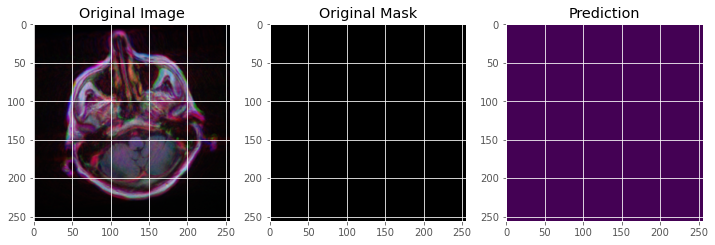

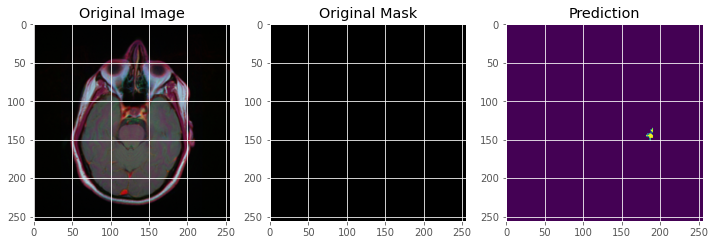

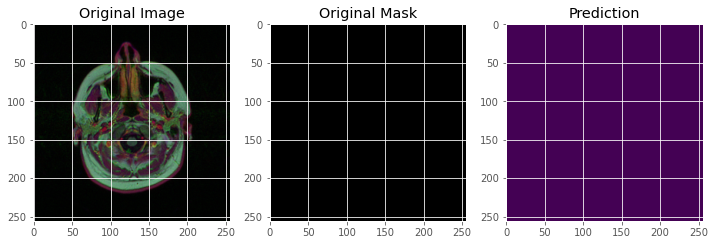

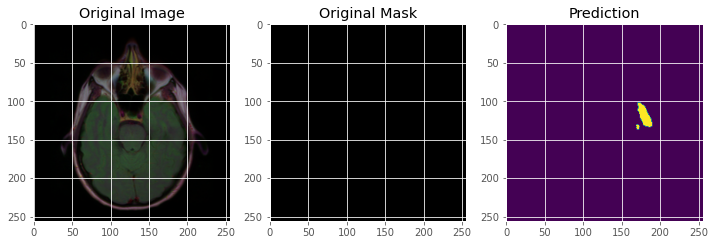

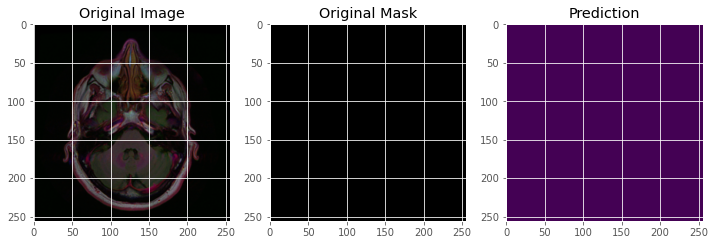

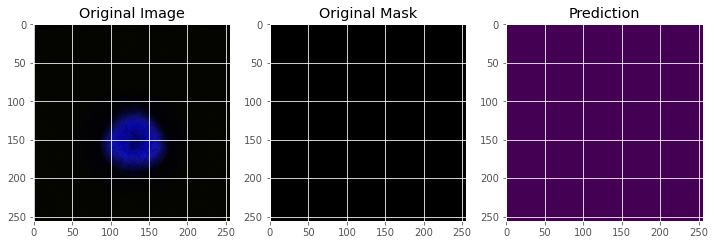

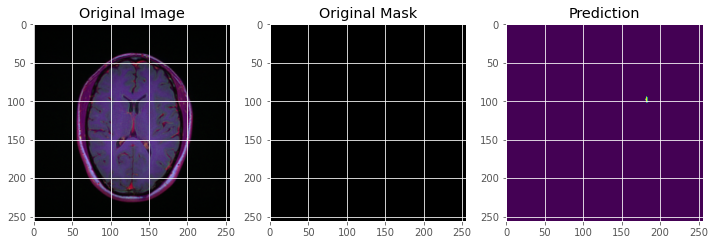

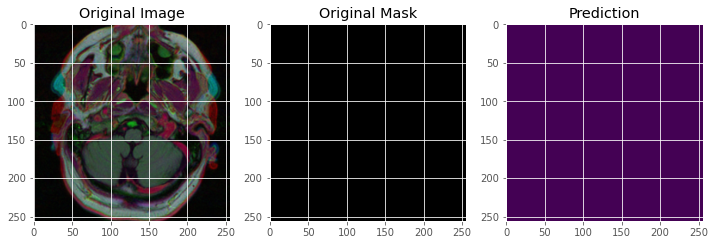

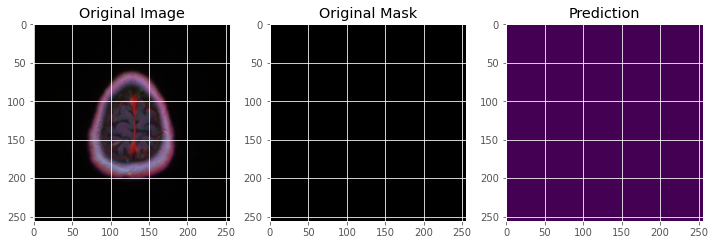

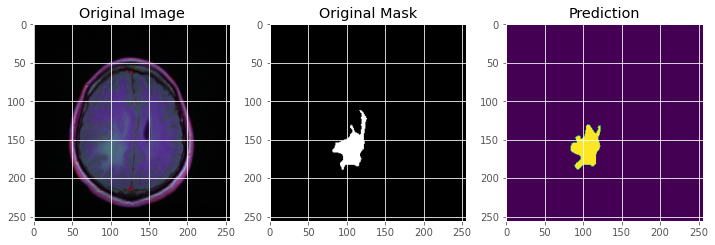

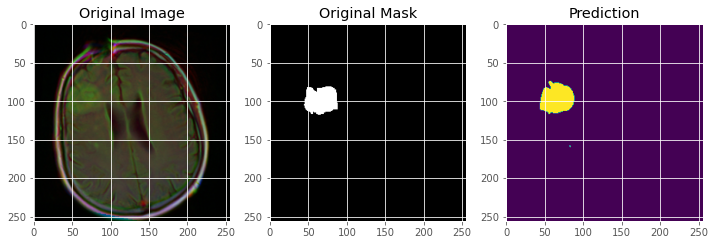

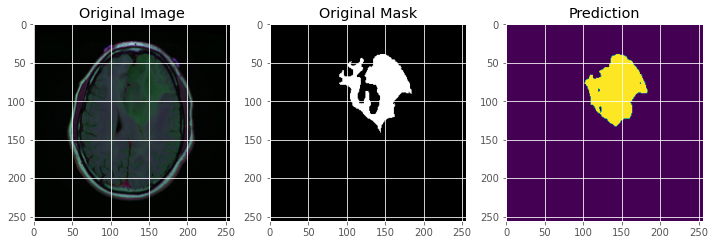

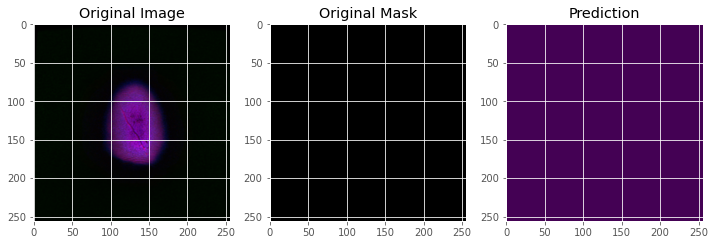

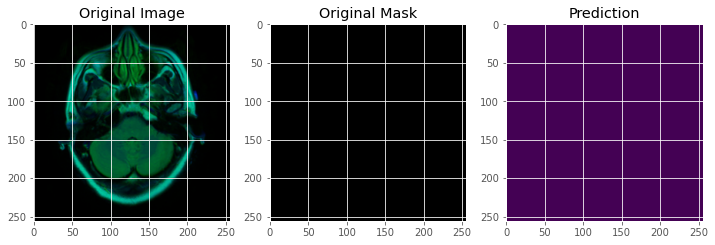

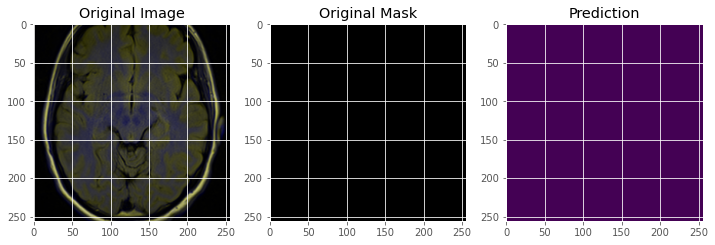

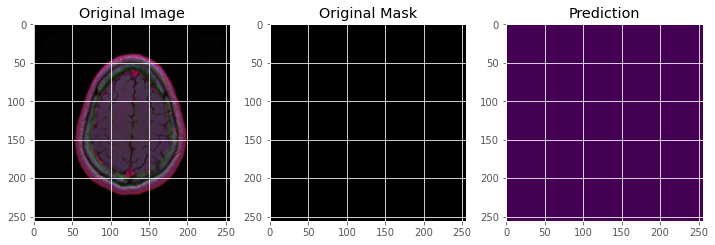

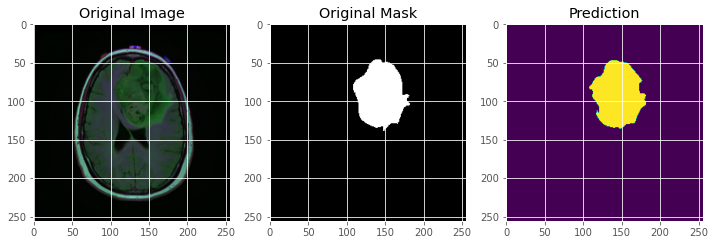

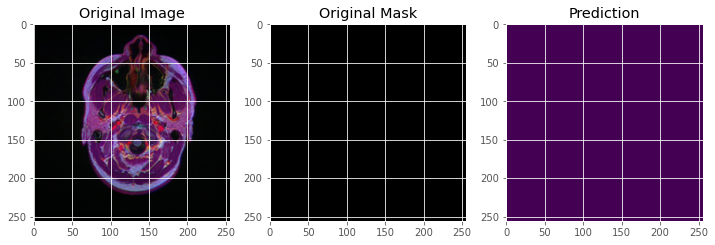

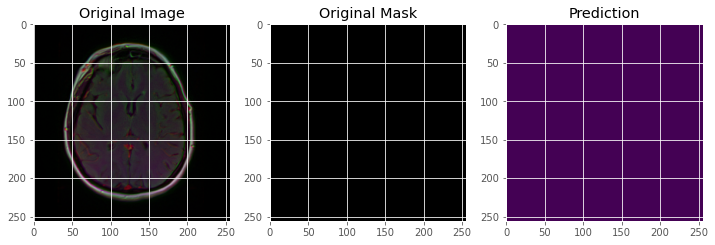

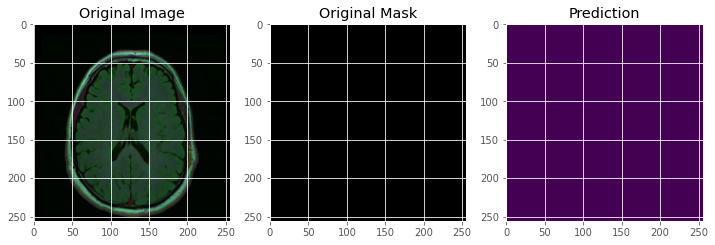

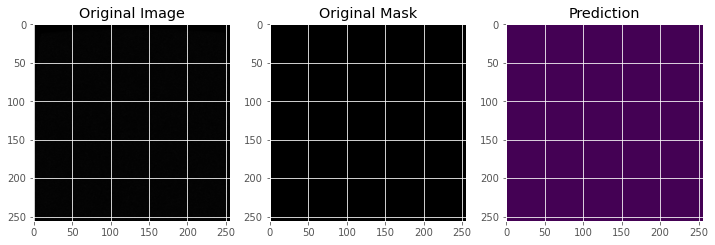

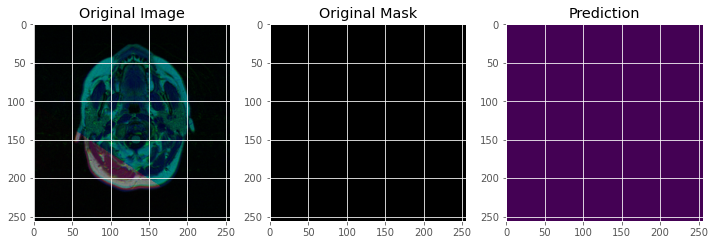

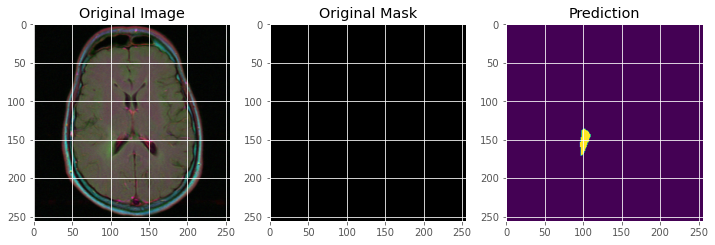

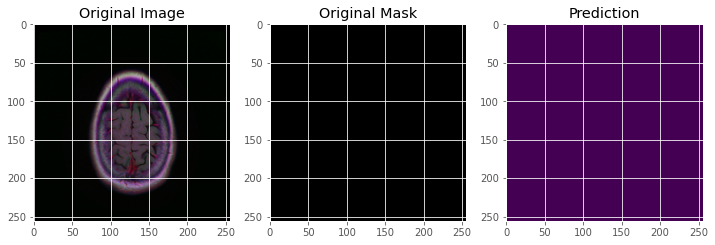

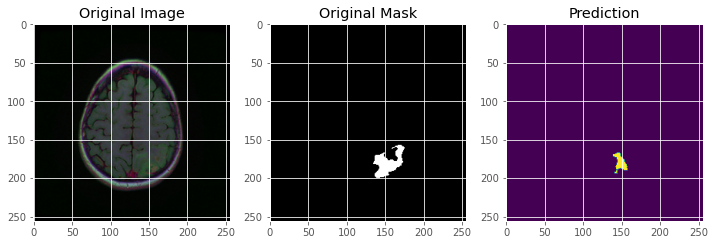

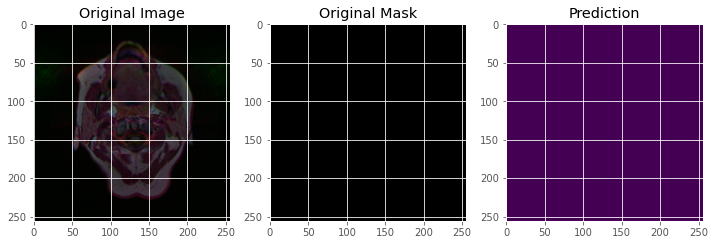

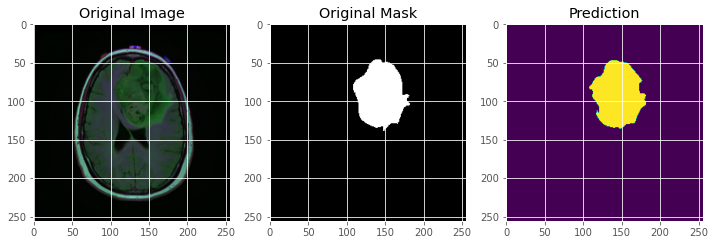

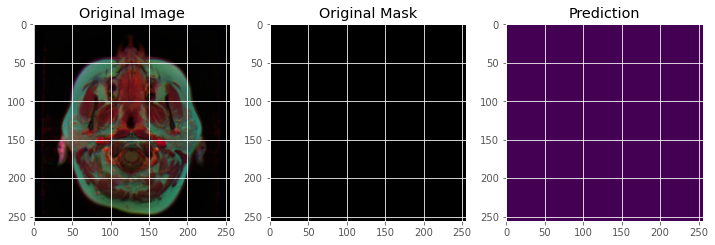

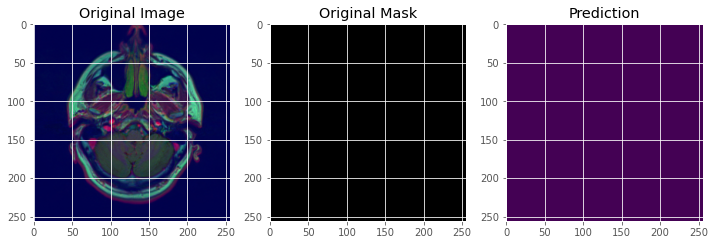

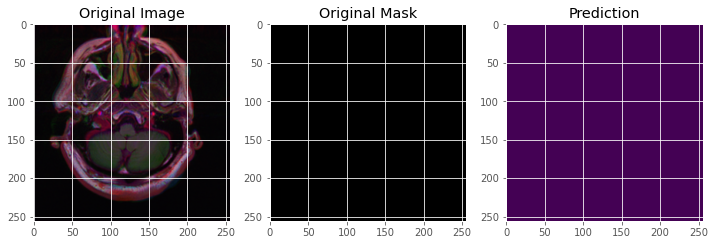

In [ ]:
for i in range(30):
    index=np.random.randint(1,len(df_test.index))
    img = cv2.imread(df_test['filename'].iloc[index])
    img = cv2.resize(img ,(height, width))
    img = img / 255
    img = img[np.newaxis, :, :, :]
    pred=last_model.predict(img)

    plt.figure(figsize=(12,12))
    plt.subplot(1,3,1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')
    plt.subplot(1,3,2)
    plt.imshow(np.squeeze(cv2.imread(df_test['mask'].iloc[index])))
    plt.title('Original Mask')
    plt.subplot(1,3,3)
    plt.imshow(np.squeeze(pred) > .5)
    plt.title('Prediction')
    plt.show()